In [ ]:
from typing import List, Tuple
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from timeit import default_timer as timer 

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms

#!pip install -q torchinfo
#from torchinfo import summary

# Note: this notebook requires torch >= 1.10.0
print(f'PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}')

PyTorch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [ ]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Download the image dataset

In [ ]:
def download_zip_file(zip_name, url):
  # Setup path to data folder
  data_path = Path('data/')
  image_path = data_path / zip_name

  # If the image folder doesn't exist, download it and prepare it... 
  if image_path.is_dir():
      print(f'{image_path} directory exists.')
  else:
      print(f'Did not find {image_path} directory, creating one...')
      image_path.mkdir(parents=True, exist_ok=True)
      
      # Download pizza, steak, sushi data
      with open(data_path / f'{zip_name}.zip', 'wb') as f:
          request = requests.get(url)
          print(f'Downloading {zip_name} dataset...')
          f.write(request.content)
          print(' Done')

      # Unzip pizza, steak, sushi data
      with zipfile.ZipFile(data_path / f'{zip_name}.zip', 'r') as zip_ref:
          print(f'Unzipping {zip_name} dataset...') 
          zip_ref.extractall(image_path)
          print(' Done')
  return image_path


Download the pizza steack sushi dataset

In [ ]:
image_path = download_zip_file('/pizza_steak_sushi', 'https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')

/pizza_steak_sushi directory exists.


Visualize the strucure and number of image of our folder

In [ ]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
    
walk_through_dir(image_path)

There are 2 directories and 0 images in '/pizza_steak_sushi'.
There are 3 directories and 0 images in '/pizza_steak_sushi/train'.
There are 0 directories and 72 images in '/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in '/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in '/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in '/pizza_steak_sushi/test'.
There are 0 directories and 31 images in '/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in '/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in '/pizza_steak_sushi/test/steak'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('/pizza_steak_sushi/train'), PosixPath('/pizza_steak_sushi/test'))

Visualize a random image

Random image path: /pizza_steak_sushi/train/sushi/2017378.jpg
Image class: sushi
Image height: 512
Image width: 512


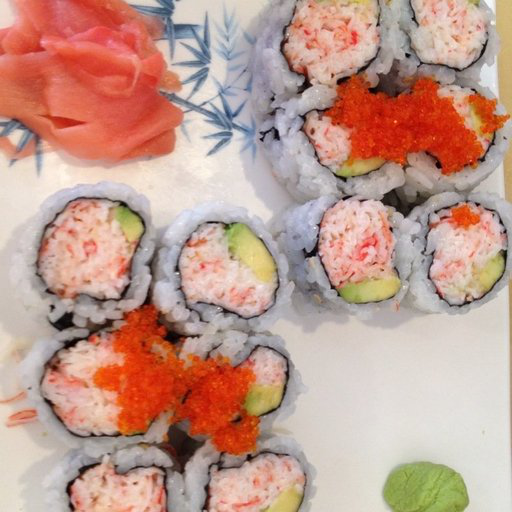

In [ ]:
# Set seed
random.seed(43) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
#image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list = list(train_dir.glob('*/*.jpg'))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f'Random image path: {random_image_path}')
print(f'Image class: {image_class}')
print(f'Image height: {img.height}') 
print(f'Image width: {img.width}')
img

Transforming our image dataset

In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
data_transform

Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
)

Visualization of orginal and transformed image for every labels

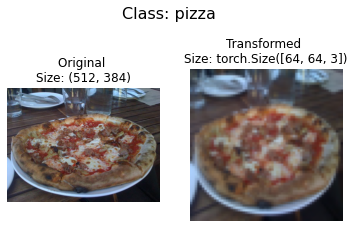

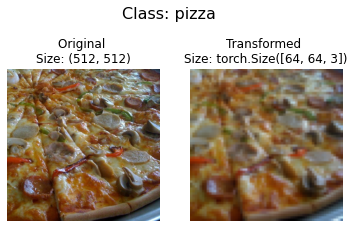

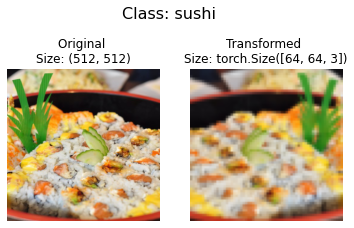

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=41):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis('off')

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis('off')

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

Get the mean and standard deviation for the transform step

In [ ]:
def get_mean_std(dataloader):
  # VAR[X] = E[X**2] - E[X]**2
  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in dataloader:
    #print(data.shape)
    channels_sum += torch.mean(data, dim=[0,1,2])
    channels_squared_sum += torch.mean(data**2, dim=[0,1,2])
    num_batches += 1
  mean = channels_squared_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2)**0.5
  return mean, std

More advanced data argumentaton

In [ ]:
#transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 

def train_transforms(dataloader):
  mean, std = get_mean_std(dataloader)
  print(mean, std)
  return transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.ColorJitter(brightness=0.4),
    #transforms.RandomInvert(p=0.5),
    transforms.RandomRotation(degrees=60),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    #transforms.RandomGrayscale(p=0.3),
    #transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.items(), std=std.items())
  ])

# the validation transforms
def test_transforms(dataloader):
  mean, std = get_mean_std(dataloader)
  print(mean, std)
  return transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.items(), std=std.items())
  ])

#train_transforms, test_transforms

Use ImageFolder to create dataset(s)

In [ ]:
basic_train_dataloader = datasets.ImageFolder(root=train_dir, transform=transforms.ToTensor())
basic_test_dataloader = datasets.ImageFolder(root=test_dir, transform=transforms.ToTensor())

Dataset ImageFolder
    Number of datapoints: 75
    Root location: /pizza_steak_sushi/test

In [ ]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms(basic_train_dataloader),
    n=3,
    seed=1
)

tensor(0.2649) tensor(0.4413)


AttributeError: ignored

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_transforms(basic_train_dataloader))

test_data = datasets.ImageFolder(root=test_dir, transform=test_transforms(basic_test_dataloader))

print(f'Train data:\n{train_data}\nTest data:\n{test_data}')

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: /pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomRotation(degrees=[-60.0, 60.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.05)
               RandomPerspective(p=1.0)
               ToTensor()
               Normalize(mean=0.2649300694465637, std=0.44129595160484314)
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: /pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=0.25927022099494934, std=0.4382341504096985)
           )


In [ ]:
# Get class names as a list
class_names = train_data.classes
print(class_names)

# Can also get class names as a dict
class_dict = train_data.class_to_idx
print(class_dict)

# Check the lengths
print(len(train_data), len(test_data))

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image tensor:\n{img}')
print(f'Image shape: {img.shape}')
print(f'Image datatype: {img.dtype}')
print(f'Image label: {label}')
print(f'Label datatype: {type(label)}')

Image tensor:
tensor([[[-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         ...,
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003]],

        [[-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         ...,
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003]],

        [[-0.6003, -0.6003, -0.6003,  ..., -0.6003, -0.6003, -0.6003],
         [-0.6003, -0.6003, -0.

Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).

Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


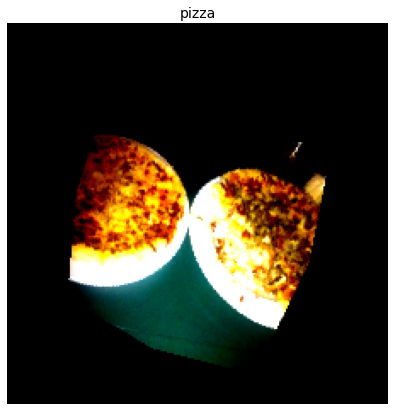

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f'Original shape: {img.shape} -> [color_channels, height, width]')
print(f'Image permute shape: {img_permute.shape} -> [height, width, color_channels]')

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Split the training set into train and validation set

In [ ]:
# let's set the validations set to the 20% of the train dataset

perc_val_size = 20
train_size = len(train_data)
val_size = (train_size * perc_val_size) / 100
train_size -= val_size

train_data, val_data = random_split(train_data, [int(train_size), int(val_size)])
len(train_data), len(val_data)

(180, 45)

Turn loaded images into DataLoader's

In [ ]:
# Turn train and test Datasets into DataLoaders
BATCH_SIZE = 36
NUM_WORKERS = os.cpu_count()

train_dl = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

val_dl = DataLoader(dataset = val_data, 
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = False)

test_dl= DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE, 
                             num_workers = NUM_WORKERS, 
                             shuffle = False) # don't usually need to shuffle testing data

# Let's check out what we've created
print(f'Dataloaders: {train_dl, val_dl, test_dl}') 
print(f'Length of train dataloader: {len(train_dl)} batches of {BATCH_SIZE}')
print(f'Length of val dataloader: {len(val_dl)} batches of {BATCH_SIZE}')
print(f'Length of test dataloader: {len(test_dl)} batches of {BATCH_SIZE}')

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fb50f93d8d0>, <torch.utils.data.dataloader.DataLoader object at 0x7fb50f93dcd0>, <torch.utils.data.dataloader.DataLoader object at 0x7fb521b80190>)
Length of train dataloader: 5 batches of 36
Length of val dataloader: 2 batches of 36
Length of test dataloader: 3 batches of 36


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dl))
print(train_features_batch.shape, train_labels_batch.shape)

val_features_batch, val_labels_batch = next(iter(val_dl))
print(val_features_batch.shape, val_labels_batch.shape)

torch.Size([36, 3, 224, 224]) torch.Size([36])
torch.Size([36, 3, 224, 224]) torch.Size([36])


TODO:


1. Lavorare con train e validation set ma testare solo sui test -> merge_tutorial_cnn_CIFRA10: **OK**
2. Scegliere la struttura piu' bella personalmente -> learn pythorch zero to master: **OK**
3. Generare più modelli per capire come funziona la creazione di una rete neurale e poter fare un contronto:
4. Vedere le slide per il continuo:
5. Utilizzare i moduli quindi portare il progetto da Google Colab su macchina fisica -> learn pythorch zero to master:



In [ ]:
'''
        n_out = |_ (n_in + 2p - k) / s _| + 1
          n_in = number of input features
          n_out = number of output featuers
          k = convolutional kernel size
          p = convolutional padding sze
          s = convoutional stride size
'''

'\n        n_out = |_ (n_in + 2p - k) / s _| + 1\n          n_in = number of input features\n          n_out = number of output featuers\n          k = convolutional kernel size\n          p = convolutional padding sze\n          s = convoutional stride size\n'

In [ ]:
VGG_types = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGnet(nn.Module):
  def __init__(self, in_channels, num_classes, typ):
    super(VGGnet, self).__init__()
    self.in_channels = in_channels
    self.typ = typ
    self.conv_layers = self.create_conv_layers(VGG_types[self.typ])

    self.fcs = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=1000, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=1000, out_features=1000, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.6,inplace=False),
            nn.Linear(in_features=1000,out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=num_classes)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fcs(x)
    return x

  def create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == int:
        out_channels = x

        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                  nn.BatchNorm2d(x),
                  nn.ReLU()]

        in_channels = x
      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*layers)

In [ ]:
class CNN_Architecture():

  def __init__(self, model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
    val_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module, accuracy_fn, scheduler: torch.optim.Optimizer, device: torch.device, save_check = False):

    self.model = model.to(device)
    self.optimizer = optimizer
    self.train_dataloader = train_dataloader
    self.loss_fn = loss_fn
    self.val_dataloader = val_dataloader
    self.accuracy_fn = accuracy_fn
    self.scheduler = scheduler
    self.device = device
    self.save_check = save_check

  def __save_checkpoint(self, train_loss, train_acc, epoch):
    data_path = Path('data/')
    filename = f'{self.model.typ}_checkpoint.pth.tar'
    print('=> Saving Checkpoint')
    checkpoint = {'state_dict': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'train_loss': train_loss, 'train_acc': train_acc, 'epoch': epoch}
    torch.save(checkpoint, filename)
    print(' DONE\n')

  def __load_checkpoint(self,checkpoint):
    self.model.load_state_dict(checkpoint['state_dict'])
    self.optimizer.load_state_dict(checkpoint['optimizer'])
  

  def evaluate(self, val_dataloader: torch.utils.data.DataLoader, epoch = 1, epochs = 1):
    val_loss, val_acc = 0, 0
    self.model.eval()

    pbar = tqdm(enumerate(val_dataloader), total = len(val_dataloader), leave=False) #, desc='EVALUATION'

    with torch.inference_mode():
      for batch_idx, (image, label) in pbar:
        image, label = image.to(self.device), label.to(self.device)
        output = self.model(image)
        loss = self.loss_fn(output, label)
        acc = self.accuracy_fn(output, label)
        val_loss += loss
        val_acc += acc

        pbar.set_description(f'EVALUATION Epoch [{epoch + 1} / {epochs}]')
        pbar.set_postfix(loss = loss.item(), acc = acc.item())
        
      val_loss /= len(val_dataloader) # already calculate the mean of all loss
      val_acc /= len(val_dataloader) # already calculate the mean of all accuracy

    return { 'model_name': self.model.__class__.__name__, # only works when model was created with a class
             'model_loss': val_loss.item(),
             'model_acc': val_acc.item() }



  def fit(self, epochs: int):
    results = { 'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [] }
    best_train_loss, best_train_acc = float('inf'), float('-inf')

    for epoch in range(epochs):
      train_loss, train_acc = 0, 0

      # Training phase
      self.model.train()

      pbar = tqdm(enumerate(self.train_dataloader), total = len(self.train_dataloader), leave=False) #, desc='TRAIN'
      
      for batch_idx, (image, label) in pbar:
        # zero_grad -> backword -> step

        self.optimizer.zero_grad()
        image, label = image.to(self.device), label.to(self.device)
        
        output = self.model(image)
        loss = self.loss_fn(output, label)
        loss.backward()
        self.optimizer.step()

        train_loss += loss.item()
        acc = self.accuracy_fn(output, label).item()

        train_acc += acc

        pbar.set_description(f'TRAIN Epoch [{epoch + 1} / {epochs}]')
        pbar.set_postfix(loss = loss.item(), acc = acc)

      train_loss /= len(self.train_dataloader)
      train_acc /= len(self.train_dataloader)


      self.scheduler.step(train_loss)

      if(self.save_check):
        if(train_loss < best_train_loss and train_acc > best_train_acc):
          self.__save_checkpoint(train_loss, train_acc, epoch + 1)
          best_train_loss, best_train_acc = train_loss, train_acc

      # Validation phase
      model_name, val_loss, val_acc = (self.evaluate(self.val_dataloader, epoch, epochs)).values()


      results['train_loss'].append(train_loss)
      results['train_acc'].append(train_acc)
      results['val_loss'].append(val_loss)
      results['val_acc'].append(val_acc)

      print('Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f} \n'.format(
            epoch + 1, train_loss, train_acc, val_loss, val_acc))

    return {'model_name': model_name, 'results': results}


  def evaluate_and_plot_image(self, image_path: str, class_names, transform=None, mean=None, std=None):
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    self.model.to(self.device)

    # 5. Turn on model evaluation mode and inference mode
    self.model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = self.model(transformed_image.to(self.device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
# Set number of epochs
NUM_EPOCHS = 30

vgg_net = VGGnet(in_channels=3, num_classes=len(class_names), typ='VGG16')

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # we are using CR loss so there is no need to add softmax layer as output
optimizer = torch.optim.Adam(params = vgg_net.parameters(), lr = 0.0001, weight_decay=1e-3)
#optimizer = torch.optim.SGD(params=vgg_net.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False)


print(vgg_net)

VGGnet(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), 

In [ ]:
cnn_model_vgg = CNN_Architecture(model = vgg_net, 
             train_dataloader = train_dl,
             val_dataloader = val_dl,
             optimizer = optimizer,
             loss_fn = loss_fn,
             accuracy_fn = accuracy,
             scheduler = scheduler,
             device = device)

# Train model
start_time = timer()
history_tvgg = cnn_model_vgg.fit(NUM_EPOCHS)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.1101, train_acc: 0.3278, val_loss: 1.1023, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.1527, train_acc: 0.3778, val_loss: 1.1073, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.1417, train_acc: 0.3611, val_loss: 1.1405, val_acc: 0.2361 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.1451, train_acc: 0.3333, val_loss: 1.1245, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5], train_loss: 1.1035, train_acc: 0.3667, val_loss: 1.1410, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.1584, train_acc: 0.2556, val_loss: 1.1344, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.1507, train_acc: 0.3000, val_loss: 1.1227, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.1333, train_acc: 0.3667, val_loss: 1.1137, val_acc: 0.2917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1039, train_acc: 0.4056, val_loss: 1.0796, val_acc: 0.3333 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.0537, train_acc: 0.4278, val_loss: 0.9884, val_acc: 0.5556 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.0807, train_acc: 0.4056, val_loss: 0.9692, val_acc: 0.5278 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.9754, train_acc: 0.5000, val_loss: 0.9420, val_acc: 0.5417 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.9189, train_acc: 0.5722, val_loss: 1.4386, val_acc: 0.2639 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.8875, train_acc: 0.5333, val_loss: 1.5864, val_acc: 0.3333 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.8503, train_acc: 0.6222, val_loss: 1.3127, val_acc: 0.4722 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.8576, train_acc: 0.5722, val_loss: 4.1499, val_acc: 0.3333 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.8124, train_acc: 0.5889, val_loss: 4.3957, val_acc: 0.3333 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.7778, train_acc: 0.6444, val_loss: 5.2434, val_acc: 0.3194 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.7680, train_acc: 0.6167, val_loss: 2.2592, val_acc: 0.5556 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7397, train_acc: 0.6278, val_loss: 2.0831, val_acc: 0.4861 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.6895, train_acc: 0.6556, val_loss: 4.5512, val_acc: 0.3750 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6881, train_acc: 0.7056, val_loss: 2.2434, val_acc: 0.4028 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.7135, train_acc: 0.7222, val_loss: 1.3122, val_acc: 0.6250 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6126, train_acc: 0.7278, val_loss: 3.6796, val_acc: 0.3611 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.6168, train_acc: 0.7389, val_loss: 1.5475, val_acc: 0.5972 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.6274, train_acc: 0.7389, val_loss: 1.9456, val_acc: 0.5833 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.5560, train_acc: 0.7889, val_loss: 1.7197, val_acc: 0.6944 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.5439, train_acc: 0.7667, val_loss: 2.0227, val_acc: 0.6389 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.5618, train_acc: 0.7278, val_loss: 3.3511, val_acc: 0.4861 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.6113, train_acc: 0.7389, val_loss: 3.1400, val_acc: 0.4444 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.5912, train_acc: 0.7444, val_loss: 1.5358, val_acc: 0.6389 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.5608, train_acc: 0.7444, val_loss: 1.4189, val_acc: 0.6944 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.4894, train_acc: 0.8389, val_loss: 2.5405, val_acc: 0.6389 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.5004, train_acc: 0.8444, val_loss: 3.6127, val_acc: 0.3611 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.5894, train_acc: 0.7444, val_loss: 1.5763, val_acc: 0.7083 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.4771, train_acc: 0.8000, val_loss: 2.0571, val_acc: 0.6528 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.4760, train_acc: 0.8111, val_loss: 2.0259, val_acc: 0.7083 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.4155, train_acc: 0.8611, val_loss: 1.6395, val_acc: 0.7361 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.3471, train_acc: 0.8556, val_loss: 1.1397, val_acc: 0.7917 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.4401, train_acc: 0.8444, val_loss: 0.9553, val_acc: 0.6667 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.5176, train_acc: 0.8333, val_loss: 0.9424, val_acc: 0.6250 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.3798, train_acc: 0.8722, val_loss: 0.9574, val_acc: 0.5833 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.3148, train_acc: 0.8889, val_loss: 1.6313, val_acc: 0.6250 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.3403, train_acc: 0.8722, val_loss: 1.6104, val_acc: 0.6528 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.5363, train_acc: 0.8056, val_loss: 1.5208, val_acc: 0.6250 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.4063, train_acc: 0.8667, val_loss: 5.9893, val_acc: 0.3194 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.4673, train_acc: 0.8056, val_loss: 2.2615, val_acc: 0.5556 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.4060, train_acc: 0.8833, val_loss: 1.2042, val_acc: 0.7222 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.3526, train_acc: 0.8667, val_loss: 1.1001, val_acc: 0.6528 



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.3246, train_acc: 0.8833, val_loss: 0.9435, val_acc: 0.6389 

Total training time: 178.262 seconds


Compare the results between train and validation set

In [ ]:
def plot_loss_curves(results_info):
  res = results_info['results']
  # Figure out how many epochs there were
  epochs = range(len(res['train_loss']))

  # Setup a plot 
  plt.figure(figsize = (15, 7))
  plt.title(results_info['model_name'])

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, res['train_loss'], label = 'train_loss')
  plt.plot(epochs, res['val_loss'], label = 'val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, res['train_acc'], label = 'train_accuracy')
  plt.plot(epochs, res['val_acc'], label = 'val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

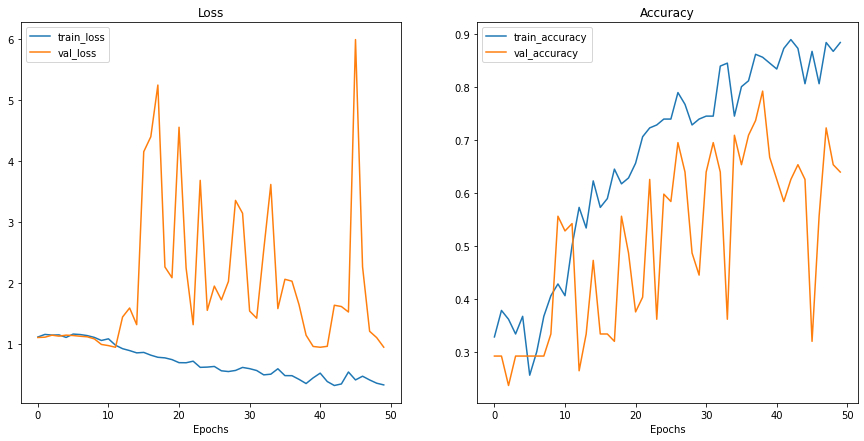

In [ ]:
plot_loss_curves(history_tvgg)

Test the model in the Test Dataloader

In [ ]:
# Evaluate model
start_time = timer()
result = cnn_model_vgg.evaluate(test_dl)
end_time = timer()

print(f'Total evaluation time: {end_time-start_time:.3f} seconds\n')
print(f"TEST Results for {result['model_name']} -> loss: {result['model_loss']} accuracy: {result['model_acc']}")

  0%|          | 0/3 [00:00<?, ?it/s]

Total evaluation time: 1.069 seconds

TEST Results for VGGnet -> loss: 0.9077867269515991 accuracy: 0.6574074074074074


Develop additional CNN for a deeper analysis

In [ ]:
def graph_compare_results(results_list):
  plt.figure(figsize = (15, 10))

  plots = [('Train Loss', 'train_loss'), ('Test Loss', 'test_loss'),
           ('Train Accuracy', 'train_acc'), ('Test Accuracy', 'test_acc')]

  epochs = range(len(results_list['results'][0]))

  for i, p in enumerate(plots):
    plt.subplot(2, 2, i)
    for model_name, res in results_list.values():
      plt.plot(epochs, res[p[1]], label = model_name)
    plt.title(p[0])
    plt.xlabel('Epochs')
    plt.legend()

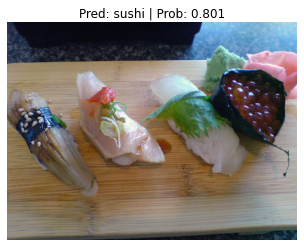

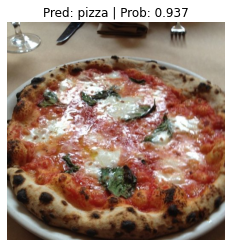

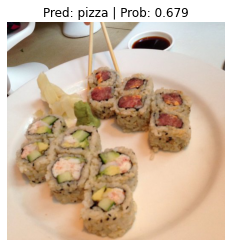

In [ ]:
random_image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

mean, std = get_mean_std(test_dl)

for image_path in test_image_path_sample:
  cnn_model_vgg.evaluate_and_plot_image(image_path=image_path,
                    class_names=class_names,
                    transform=random_image_transform, mean=mean, std=std)

Now we try to generalize a pretrained model to out problem using transfer learning

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, transform=random_image_transform)

test_data = datasets.ImageFolder(root=test_dir, transform=random_image_transform)

# let's set the validations set to the 20% of the train dataset

perc_val_size = 20
train_size = len(train_data)
val_size = (train_size * perc_val_size) / 100
train_size -= val_size

train_data, val_data = random_split(train_data, [int(train_size), int(val_size)])
len(train_data), len(val_data)

train_dl = DataLoader(dataset = train_data, 
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = True)

val_dl = DataLoader(dataset = val_data, 
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = False)

test_dl= DataLoader(dataset = test_data, 
                             batch_size = BATCH_SIZE, 
                             num_workers = NUM_WORKERS, 
                             shuffle = False) # don't usually need to shuffle testing data